# An exploration of factors affecting life expectancy in world countries
## by David Mullen

## Investigation Overview

Average life expectancy by country can vary by roughly a factor of two. Are there predictors for these differences? In this study, a few of these factors will be examined - location by continent, income and healthcare spending per capita, and the presence or lack of universal healthcare.

## A note on methods

The bulk of the data for this study was acquired from Gapminder.org, augmented by two important additional data types - the country's continent, and the presence or lack of universal healthcare. This data was gathered from the relevant Wikipedia pages. A single year was selected for this study, based on maximization of availability of data, between 2005 and 2015. The year examined by this study is 2009.

In [1]:
# to view these slides, at a command prompt in the file's directory:
# jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle

# import all packages
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.api as sm
from bs4 import NavigableString, BeautifulSoup
import os

# set plots to be embedded inline
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
data = 'data/gapminder_data_wrangled.csv'
df = pd.read_csv(data, header=0, index_col=0)

## Countries included in this study

There are 187 countries included in this study, described below. 

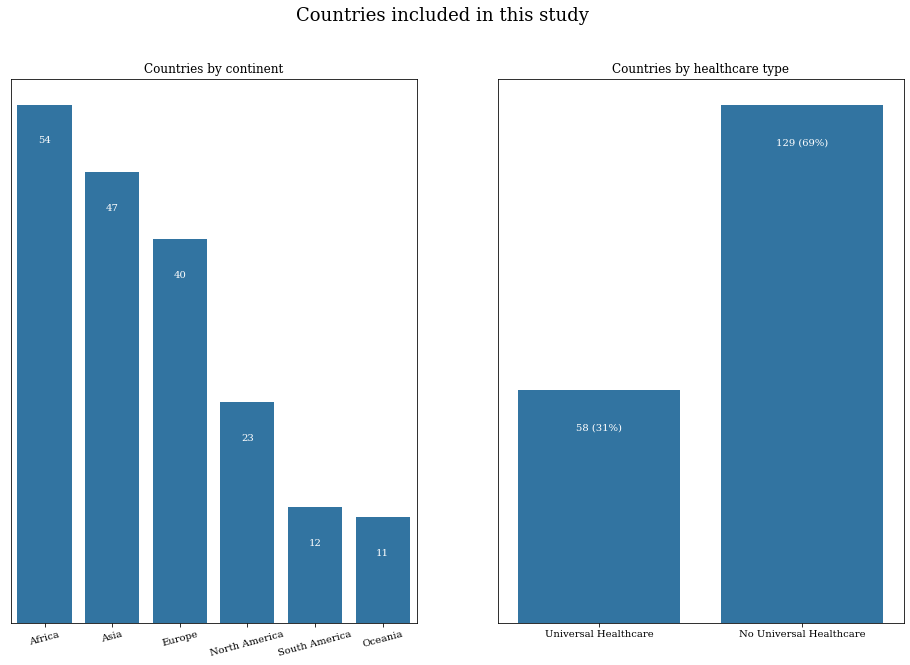

In [3]:
# create temp df: df_g, for graphing.
df_g = df
df_g["uhc_str"] = np.where(df_g.uhc == True, 'Universal Healthcare', 'No Universal Healthcare')
df_g.head()

# create a figure and select a color for all bars
plt.figure(figsize = [16,10])
base_color = sb.color_palette()[0]
plt.suptitle("Countries included in this study", y = .98, fontsize = 18)

###### GRAPH 1
plt.subplot(1, 2, 1)
# sort by count
ax1 = sb.countplot(data = df_g, x = 'continent', color = base_color, \
                  order = df_g['continent'].value_counts().index)

# add annotations
n_points = df_g.shape[0]
cat_counts = df_g['continent'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{}'.format(count)
    # print the annotation just below the top of the bar
    plt.text(loc, count-4, pct_string, ha = 'center', color = 'w')

# make label and aesthetic changes
plt.title("Countries by continent")
plt.xticks(rotation = 15)
ax1.set(xlabel="", ylabel = "")
ax1.set_yticks([])


###### GRAPH 2
plt.subplot(1, 2, 2)
# graph is most readable with uhc first.
cat_list = ['Universal Healthcare', 'No Universal Healthcare']
ax2 = sb.countplot(data = df_g, x = 'uhc_str', color = base_color, \
                  order = cat_list)

# add annotations
n_points = df_g.shape[0]
cat_counts = df_g['uhc_str'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{} ({:0.0f}%)'.format(count, 100*count/n_points)
    # print the annotation just below the top of the bar
    plt.text(loc, count-10, pct_string, ha = 'center', color = 'w')

# make label and aesthetic changes
plt.title("Countries by healthcare type")
ax2.set(xlabel="", ylabel = "")
ax2.set_yticks([]);

## A simple look at life expectancy

The chart below shows a simple distribution of life expectancies across the countries in this study. We see quite a bit of variation between countries, which will be explored in the following slides. 

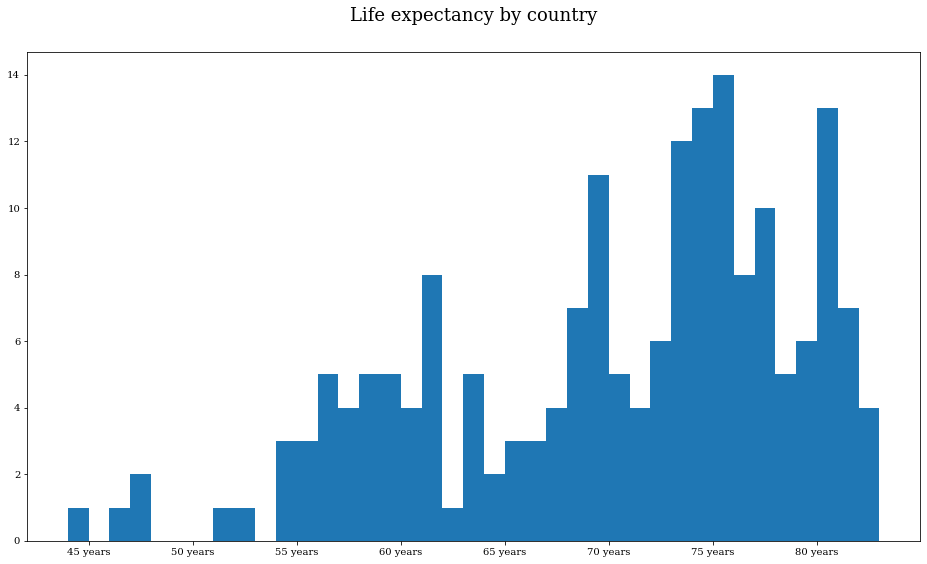

In [4]:
BIN_SIZE = 1

plt.figure(figsize = [16, 9])
bins_list = np.arange(int(df['le'].min()), int(df['le'].max()) + BIN_SIZE, BIN_SIZE)
plt.title("Life expectancy by country", y = 1.05, fontsize = 18)

xtick_locs = np.arange(0, df['le'].max()+3, 5)
xtick_props = ['{} years'.format(int(v)) for v in xtick_locs]
plt.xticks(xtick_locs, xtick_props)

plt.hist(data = df, x = 'le', bins=bins_list);

## Life expectancy by continent _or_ by healthcare type

What we can see in the charts below is that both location by continent, and the presence or lack of universal healthcare both are predictors of life expectancy.

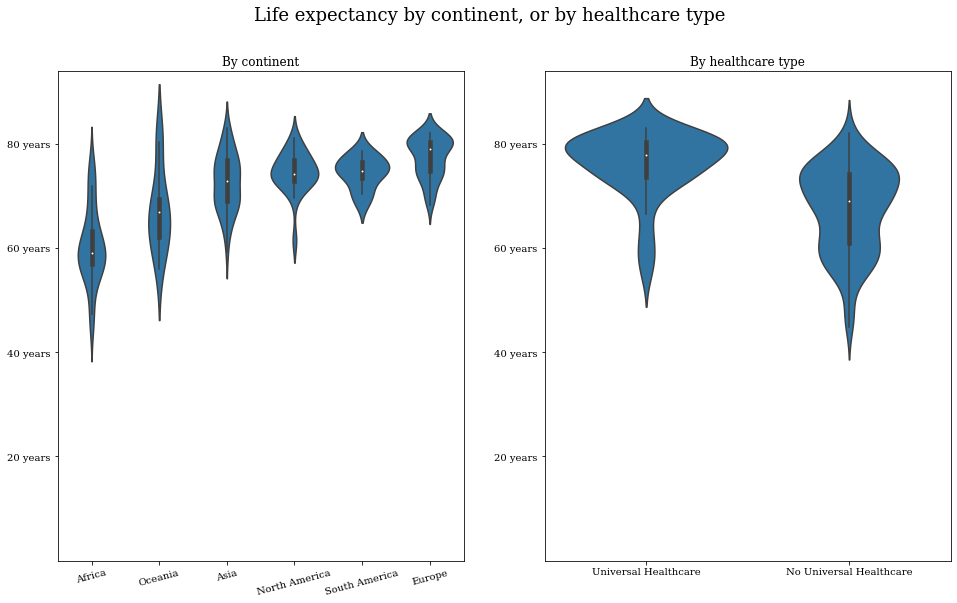

In [5]:
plt.figure(figsize = [16,9])
base_color = sb.color_palette()[0]
plt.suptitle("Life expectancy by continent, or by healthcare type", y = .98, fontsize = 18)


##### GRAPH 1 ######
plt.subplot(1,2,1)
continent_list = ['Africa', 'Oceania', 'Asia', 'North America', 'South America', 'Europe']
vclasses = pd.api.types.CategoricalDtype(ordered = True, categories = continent_list)
df_g.continent = df_g.continent.astype(vclasses)

sb.violinplot(data = df_g, x = 'continent', y = 'le', color = base_color)
plt.xticks(rotation = 15)
plt.xlabel('')
plt.ylabel('')
plt.title('By continent')
plt.ylim(0,94);

ytick_locs = np.arange(20, 90, 20)
ytick_props = ['{} years'.format(int(v)) for v in ytick_locs]
plt.yticks(ytick_locs, ytick_props)

##### GRAPH 2 ######
plt.subplot(1,2,2)
uhc_list = ['Universal Healthcare', 'No Universal Healthcare']
vclasses = pd.api.types.CategoricalDtype(ordered = True, categories = uhc_list)
df_g.uhc_str = df_g.uhc_str.astype(vclasses)

sb.violinplot(data = df_g, x = 'uhc_str', y = 'le', color = base_color)
#plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('By healthcare type')
plt.ylim(0,94)

ytick_locs = np.arange(20, 90, 20)
ytick_props = ['{} years'.format(int(v)) for v in ytick_locs]
plt.yticks(ytick_locs, ytick_props);

## Life expectancy by continent _and_ healthcare type

The chart below examines the relationship between the predictive value of continent combined with the presence or lack of universal healthcare. We can see that in some continents the difference between the universal and non-universal groups is larger than in some other continents.

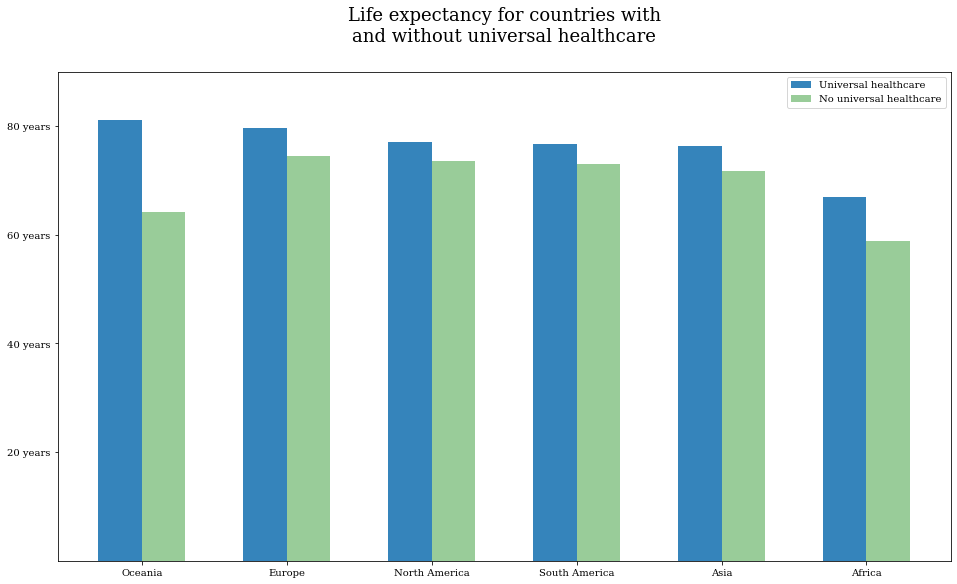

In [6]:
continent_list = ['Oceania','Europe','North America', 'South America', 'Asia', 'Africa']

vclasses = pd.api.types.CategoricalDtype(ordered = True, categories = continent_list)
df_g.continent = df_g.continent.astype(vclasses)

uhc_means = df_g.query('uhc==True').groupby('continent').le.mean()
no_uhc_means = df_g.query('uhc==False').groupby('continent').le.mean()

fig, ax = plt.subplots(figsize=(16,9))

ind = np.arange(uhc_means.shape[0])    # the x locations for the groups
width = 0.3                            # the width of the bars
p1 = plt.bar(ind, uhc_means, width, bottom=0, color = base_color, alpha = .9)
p2 = plt.bar(ind + width, no_uhc_means, width, bottom=0, color = 'green', alpha = .4)

ax.set_title('Life expectancy for countries with\nand without universal healthcare', y = 1.05, fontsize = 18)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((uhc_means.index.values))
ax.set_ylim(0,90)
ax.legend((p1[0], p2[0]), ('Universal healthcare', 'No universal healthcare'))

ytick_locs = np.arange(20, 90, 20)
ytick_props = ['{} years'.format(int(v)) for v in ytick_locs]
plt.yticks(ytick_locs, ytick_props)

plt.show();

## Income and healthcare spending

The slide below shows per capita income vs life expectancy beside a graph of healthcare spending per capita vs life expectancy. A full numeric analysis is outside the scope of this project, but a reasonable assumption from what we see in these charts is that there isn't much difference in predictive value between the two.

In [7]:
# I want this function to be versatile, reusable, specific, and (if needed) verbose. 
# We'll have separate parameters for head and tail.
def remove_head_and_tail(df, column, nhead, ntail):
    # if nhead or ntail is zero, numpy handles it without me needing to validate
    outliers_list = np.append(df.nlargest(nhead, column).index.values, \
                              df.nsmallest(ntail, column).index.values)
    #print("Outliers are:", outliers_list)
    smallest_list = df.nsmallest(ntail, column).index.values
    #print("length before drop: ", len(df.index))
    df_return = df.drop(outliers_list)
    #print("length after drop: ", len(df_return.index))
    return df_return

# remove a few outliers first, selected by visualization of the graph.
df_gtemp1 = remove_head_and_tail(df_g, 'ic', 8, 0)
df_gtemp2 = remove_head_and_tail(df_gtemp1, 'le', 1, 0)
df_g1 = remove_head_and_tail(df_gtemp2, 'th', 1, 0)

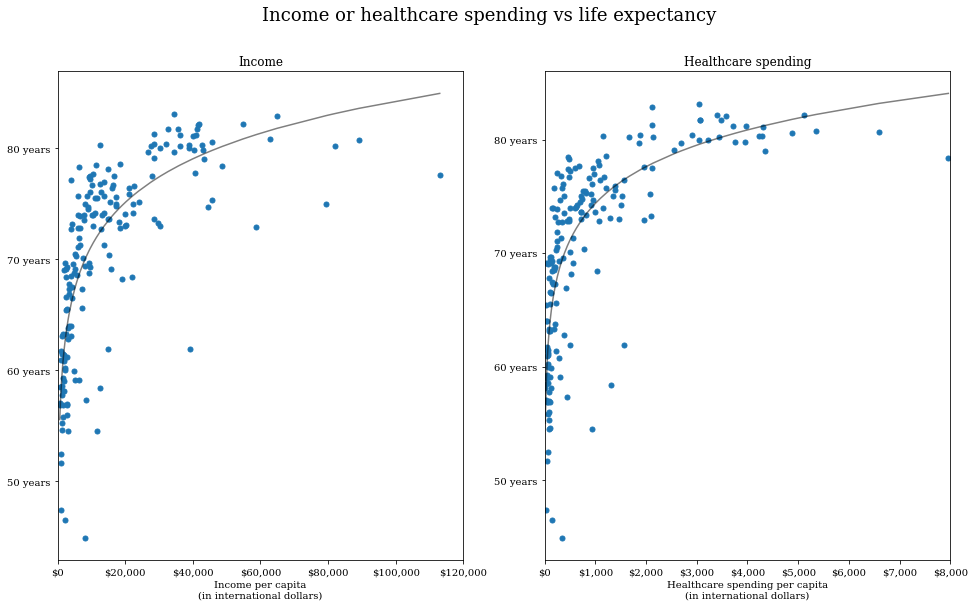

In [8]:
df_no_th_nulls = df.query('th == th')

y = df_no_th_nulls.loc[:,'le'].values
x1 = df_no_th_nulls.loc[:,'ic'].values
x2 = df_no_th_nulls.loc[:,'th'].values

fig = plt.figure(figsize=(16, 9))
plt.suptitle("Income or healthcare spending vs life expectancy", y = .98, fontsize = 18)

plt.subplot(1,2,1)
plt.scatter(x1, y, alpha=1, marker='.', s = 100, color=base_color)
plt.xlabel('Income per capita\n(in international dollars)')
#plt.ylabel('Life expectancy in years')
plt.title('Income')
plt.xlim(0, x1.max())

# xticks will only need formatting.
xtick_locs = np.arange(0, df_no_th_nulls['ic'].max()+10000, 20000)
xtick_props = ['${:,}'.format(int(v)) for v in xtick_locs]
plt.xticks(xtick_locs, xtick_props)

ytick_locs = np.arange(20, 90, 10)
ytick_props = ['{} years'.format(int(v)) for v in ytick_locs]
plt.yticks(ytick_locs, ytick_props)

# Note: sorting is necessary to keep matplotlib from drawing multiple curves
mlog, blog = np.polyfit(np.log(x1), y, 1)
plt.plot(np.sort(x1), mlog*np.log(np.sort(x1)) + blog, color='black', alpha = .5);

plt.subplot(1,2,2)
plt.scatter(x2, y, alpha=1, marker='.', s = 100, color=base_color)
plt.xlabel('Healthcare spending per capita\n(in international dollars)')
#plt.ylabel('Life expectancy in years')
plt.title('Healthcare spending')
plt.xlim(0, x2.max())

# xticks will only need formatting.
xtick_locs = np.arange(0, df_no_th_nulls['th'].max()+1000, 1000)
xtick_props = ['${:,}'.format(int(v)) for v in xtick_locs]
plt.xticks(xtick_locs, xtick_props)

ytick_locs = np.arange(20, 90, 10)
ytick_props = ['{} years'.format(int(v)) for v in ytick_locs]
plt.yticks(ytick_locs, ytick_props)

# Note: sorting is necessary to keep matplotlib from drawing multiple curves
mlog, blog = np.polyfit(np.log(x2), y, 1)
plt.plot(np.sort(x2), mlog*np.log(np.sort(x2)) + blog, color='black', alpha = .5);

## Income weighted by population

Because income and healthcare spending are so similar in effect, we will assume only one at this point needs to be examined further to estimate the effect of the other. However, population hasn't been taken into account so far. The chart below will recalculate the previous chart, this time with population weighting in drawing the trend line, and with population visible via dot size on the graph. Also note that universal healthcare countries are specified.

Conclusions drawn from this graph are:
- Yes, per capita income is a predictor of life expectancy at the country level.
- Countries with universal healthcare tend to be both richer and with longer average life expectancies.
- Population does not appear to be a strong predictor of life expectancy or participation in universal healthcare.

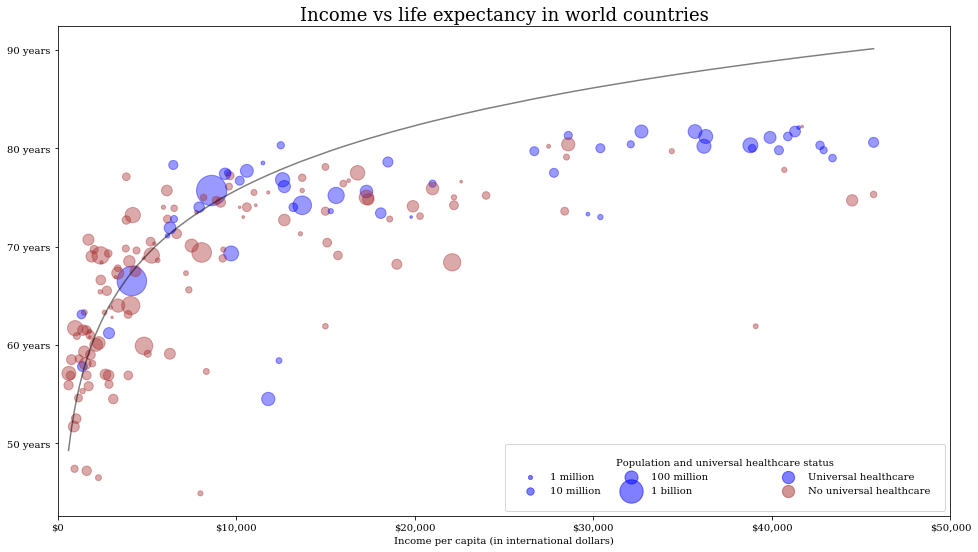

In [9]:
fig = plt.figure(figsize=(16,9))

y = df_g1.loc[:,'le'].values
x = df_g1.loc[:,'ic'].values
z = df_g1.pp.values

size = np.sqrt(df_g1.pp/100)

df_g1['color'] = 'brown'
df_g1.loc[df_g1.uhc==True, 'color'] = 'blue'
    
plt.scatter(x, y, alpha=0.40, marker='.', s=size, color=df_g1['color'])

plt.xlabel('Income per capita (in international dollars)')
plt.xlim(left=0)
plt.title('Income vs life expectancy in world countries', fontsize = 18)

# xticks will only need formatting.
xtick_locs = np.arange(0, df_g1['ic'].max()+5000, 10000)
xtick_props = ['${:,}'.format(int(v)) for v in xtick_locs]
plt.xticks(xtick_locs, xtick_props)

ytick_locs = np.arange(20, 95, 10)
ytick_props = ['{} years'.format(int(v)) for v in ytick_locs]
plt.yticks(ytick_locs, ytick_props)

# Note: sorting is necessary to keep matplotlib from drawing multiple curves
mlog, blog = np.polyfit(np.log(x), y, 1, w=z)
plt.plot(np.sort(x), mlog*np.log(np.sort(x)) + blog, \
         label='Log line of best fit, coefficient is {}'.format(str(round(mlog,3))), color='black', alpha=.5)

labels = ["1 million", "10 million", "100 million", "1 billion", "", "", \
          "Universal healthcare", "No universal healthcare"]
l1 = plt.scatter([],[], s=17, alpha = .5, color='b')
l2 = plt.scatter([],[], s=55, alpha = .5,  color='b')
l3 = plt.scatter([],[], s=173, alpha = .5, color='b')
l4 = plt.scatter([],[], s=548, alpha = .5, color='b')
l5 = plt.scatter([],[], s=0, alpha = .5, color='b')
l6 = plt.scatter([],[], s=0, alpha = .5, color='b')
l7 = plt.scatter([],[], s=150, alpha = .5, color='b')
l8 = plt.scatter([],[], s=150, alpha = .5, color='brown')
leg = plt.legend([l1, l2, l3, l4, l5, l6, l7, l8], labels, ncol=4, frameon=True, fontsize=10, \
                 handlelength=2, borderpad = 1.5, handletextpad=1, \
                 title='Population and universal healthcare status', scatterpoints = 1, loc='lower right')

In [ ]:
!jupyter nbconvert slide_deck.ipynb --to slides --post serve --template output_toggle

[NbConvertApp] Converting notebook slide_deck.ipynb to slides
[NbConvertApp] Writing 648516 bytes to slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/slide_deck.slides.html
Use Control-C to stop this server
